<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

Clustering with scikit-learn

<br><br></p>

In this notebook, we will learn how to perform k-means lustering using scikit-learn in Python. 

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, we have in the order of millions records. How do we create 12 clusters our of them?

**NOTE:** The dataset we will use is in a large CSV file called *minute_weather.csv*. Please download it into the *weather* directory in your *Week-7-MachineLearning* folder. The download link is: https://drive.google.com/open?id=0B8iiZ7pSaSFZb3ItQ1l4LWRMTjg 

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Importing the Necessary Libraries<br></p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import python_utils
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

%matplotlib inline

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Creating a Pandas DataFrame from a CSV file<br><br></p>


In [2]:
data = pd.read_csv('./data_EDX_course/minute_weather_SCIKIT.csv')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Minute Weather Data Description</p>
<br>
The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Data Sampling<br></p>

Lots of rows, so let us sample down by taking every 10th row. <br>


In [5]:
# Reduced dataset with 1/10 rows of the original one
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Statistics
<br><br></p>


In [6]:
# There are two orders of magnitude of difference between the dimensions
# We will need to scale the data
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937510,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [7]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [8]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Drop all the Rows with Empty rain_duration and rain_accumulation
<br><br></p>


In [9]:
# These fields contain 0 values almost exclusively, so remove them
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [10]:
# Remove NAs
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]
rows_before - rows_after

46

In [11]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Select Features of Interest for Clustering
<br><br></p>


In [12]:
# Remove some additional features and keep only 7
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [13]:
select_df = sampled_df[features]

In [14]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [15]:
# Parsed data
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Scale the Features using StandardScaler
<br><br></p>


The scaling is done to keep the values of different columns comparable

In [16]:
# Scaled and parsed data
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

In [17]:
X.shape

(158680, 7)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Use k-Means Clustering
<br><br></p>


In [18]:
# Apply clustering onto parsed and scaled data
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

What are the centers of 12 clusters we formed ?
<br><br></p>


In [19]:
# Coordinates of the 12 centroids
centers = model.cluster_centers_
centers

array([[ 1.19007801, -0.25468312, -1.15493166,  2.12261318, -1.0534084 ,
         2.23936256, -1.13456932],
       [ 0.71667149,  0.44894203,  0.28550213, -0.53631985,  0.47279917,
        -0.54255693, -0.76669252],
       [-0.83765454, -1.20120114,  0.37557175,  0.36904555,  0.47403811,
         0.35702563,  1.36243665],
       [-0.16370459,  0.8634041 , -1.31126777, -0.58955336, -1.16710698,
        -0.60484116, -0.64125855],
       [ 0.24471888, -0.99610161,  0.65809375, -0.547383  ,  0.8478918 ,
        -0.53015888,  1.16144381],
       [-1.18245544, -0.87048459,  0.44692904,  1.98306377,  0.53842715,
         1.94398173,  0.9088656 ],
       [-0.21057891,  0.63296915,  0.40858054,  0.73350062,  0.51675564,
         0.67164628, -0.1516111 ],
       [-0.70635479,  0.53403112,  0.17517676, -0.58447962,  0.34479891,
        -0.59791259, -0.10774813],
       [ 0.06113923, -0.78891905, -1.19730343, -0.5707786 , -1.0433185 ,
        -0.58536331,  0.87915471],
       [ 0.23405125,  0.3206

<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

Plots
<br><br></p>


Let us first create some utility functions which will help us in plotting graphs:

In [20]:
def pd_centers(featuresUsed, centers):
    '''This function creates a DF with the centroids, where the
                header is the name of each feature'''
    
    # Dimensions (names of the columns)
    colNames = list(featuresUsed)
    
    # Add column for cluster number (index)
    colNames.append('prediction')

    # Merge index column to the centroids´ IDs
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # DF with centroids´ IDs + their coordinates
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    
    return P

A parallel coordinates plot is a quick way to visualize cluster centers along all the seven dimensions of the features space.

In [21]:
def parallel_plot(data):
    '''This function takes in the data for plotting and creates a graph
            with all the clusters with different colours each'''
    
    # Define colors
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    
    # Set up axis and dimensions
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    
    # Plot
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [22]:
# Each row is a centroid
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,1.190078,-0.254683,-1.154932,2.122613,-1.053408,2.239363,-1.134569,0
1,0.716671,0.448942,0.285502,-0.536320,0.472799,-0.542557,-0.766693,1
2,-0.837655,-1.201201,0.375572,0.369046,0.474038,0.357026,1.362437,2
3,-0.163705,0.863404,-1.311268,-0.589553,-1.167107,-0.604841,-0.641259,3
4,0.244719,-0.996102,0.658094,-0.547383,0.847892,-0.530159,1.161444,4
5,-1.182455,-0.870485,0.446929,1.983064,0.538427,1.943982,0.908866,5
6,-0.210579,0.632969,0.408581,0.733501,0.516756,0.671646,-0.151611,6
7,-0.706355,0.534031,0.175177,-0.584480,0.344799,-0.597913,-0.107748,7
8,0.061139,-0.788919,-1.197303,-0.570779,-1.043318,-0.585363,0.879155,8
9,0.234051,0.320619,1.887954,-0.651815,-1.551758,-0.576694,-0.283850,9


# Dry Days

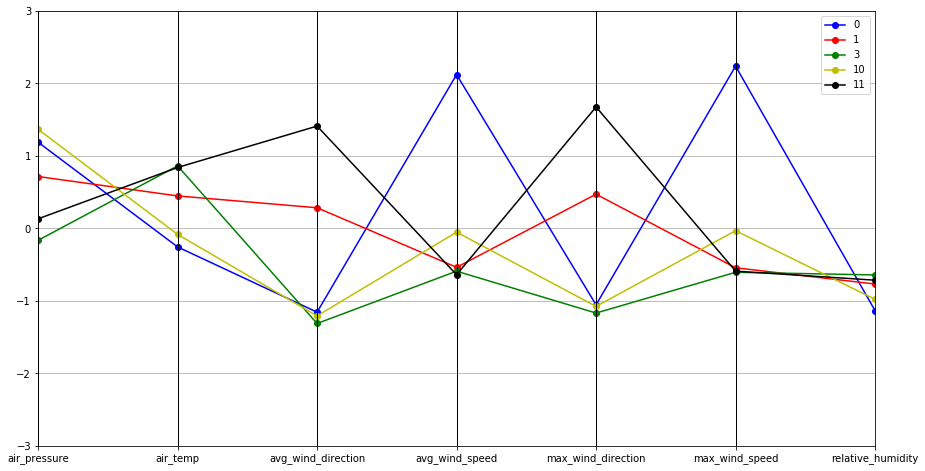

In [23]:
# X axis: features used for clustering (7) --> labels
# Y axis: coordinates of each centroid (12) --> values
parallel_plot(P[P['relative_humidity'] < -0.5])

# Warm Days

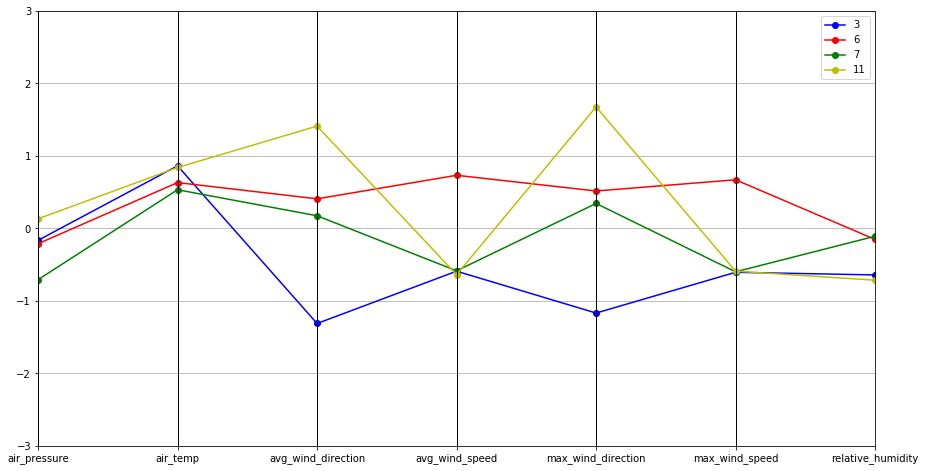

In [24]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cool Days

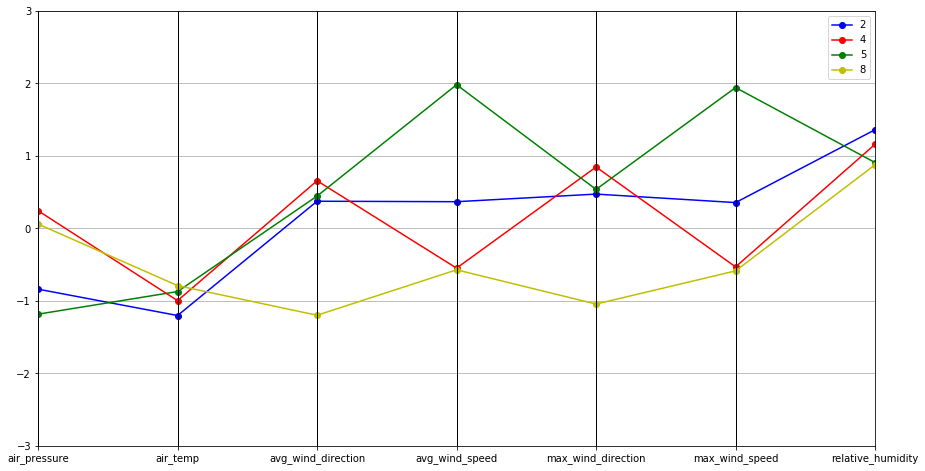

In [25]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])